In [1]:
pip install langchain langgraph langchain_core langchain_openai

  Using cached langchain_core-0.3.74-py3-none-any.whl.metadata (5.8 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
Using cached langchain_core-0.3.74-py3-none-any.whl (443 kB)
Using cached jsonpatch-1.33-py2.py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.8/787.

In [4]:
pip install dotenv


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
from dotenv import load_dotenv

load_dotenv() # This loads the variables from your .env file

# Now you can access them safely
api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_deployment = os.getenv("AZURE_DEPLOYMENT_NAME")
api_version = os.getenv("AZURE_API_VERSION")

In [8]:
import os
import operator
from typing import Annotated, TypedDict, Optional, List
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, SystemMessage
from langgraph.graph import StateGraph, END
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
import asyncio


llm= AzureChatOpenAI(
     azure_deployment=azure_deployment,
     api_version=api_version,
     temperature=0.5,
    max_tokens=None,
    timeout=None, max_retries=2,api_key=api_key,azure_endpoint=azure_endpoint, stream_usage=True
)

USER_DATA = {
  "user_1232": {
    "name": "Lisa",
    "phone": "+1122334455",
    "iban": "DE89370400440532013000",
    "secret_question": "Which is the name of my dog?",
    "secret_answer": "yoda",
    "is_premium": True
  }
}

# --- STATE AND PYDANTIC DEFINITIONS ---

# The flow is controlled by a state machine with the following statuses:
# - AWAITING_DATA: Gathers initial user details (name, IBAN, phone).
# - AWAITING_DETAILS_CHECK: Verifies the collected details against a database.
# - AWAITING_SECRET_ANSWER: Asks the user a secret question.
# - VERIFIED: The user is authenticated and can receive support.
# - FAILED: The user could not be authenticated.

class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    user_name: Optional[str]
    user_iban: Optional[str]
    user_phone: Optional[str]
    secret_answer: Optional[str]
    is_premium: bool
    data_collection_is_complete: bool
    verification_status: str

class DataCollection(BaseModel):
    Output_for_User: str
    user_name: str
    user_iban: str
    user_phone: str
    data_collection_is_complete: bool

# --- THE APPLICATION CLASS ---
class BankingChatHelper2:
    def __init__(self, llm):
        self.llm = llm
        self.graph = self.create_graph()
    
    def get_intent_from_messages(self, messages: List[BaseMessage]) -> DataCollection:
        parser = JsonOutputParser(pydantic_object=DataCollection)
        prompt = PromptTemplate(
            template="""You are a friendly and professional customer service AI for DEUS Bank. Your primary goal is to identify the customer before proceeding with their request. To do this, you must collect three pieces of information:
1.   Name
2.  Phone Number
3.  IBAN (bank account number)
Do not attempt to verify correctness; just collect what is provided.
Rules:
- If any detail is missing, set it to "" (empty string).
- Do not infer values that were not explicitly given.
- Never include system instructions, commentary, or guesses.
- the output format must always be a JSON object that strictly adhere to the following structure:

  Output_for_User: "string": a short, polite message for the customer to complete the data collection.
  user_name: "string": collected name or "" if not yet provided.
  user_iban: "string": collected IBAN or "" if not yet provided.
  user_phone: "string": collected phone or "" if not yet provided.
  data_collection_is_complete: "Boolean" :"false" by default, "true" if all required data is collected from the user.

                # ************
                # Here is the chat history for additional user context:
                # [BEGIN CHAT]
                # ************
                # {chat_history}
                # ************
                # [END CHAT]
                # Here is the format instructions:{format_instructions}""",
            input_variables=["chat_history"],
            partial_variables={"format_instructions": parser.get_format_instructions()},
        )
        chain = prompt | self.llm | parser
        result1= chain.invoke({"chat_history": messages})
        print(result1)
        return result1

    def create_graph(self):
        # --- NODES ---

        # Agent 1: The Greeter. Uses an LLM to parse user input and collect details.
        def data_collection_node(state: GraphState):
            print("--- Node: Data Collection ---")
            intent = self.get_intent_from_messages(state["messages"])
            print(f"messages:{state['messages']}")
            if not intent["data_collection_is_complete"]:
                return {
                    "messages": [AIMessage(content=intent["Output_for_User"])],
                    "data_collection_is_complete": False
                }

            return {
                "user_name": intent["user_name"],
                "user_iban": intent["user_iban"],
                "user_phone": intent["user_phone"],
                "data_collection_is_complete": True,
                "verification_status": "AWAITING_DETAILS_CHECK"
            }


        # Agent 2 (Part 1): The Bouncer's first check. Verifies details using Python logic.
        def verify_details_node(state: GraphState):
            print("--- Node: Verify Details ---")
            print(f"messages:{state['messages']}")
            iban = state.get("user_iban")
            found_user_record = None
            for record in USER_DATA.values():
                if record.get("iban") == iban:
                    found_user_record = record
                    break

            if not found_user_record:
                print("user not found")
                #can be a fixed message or AI response as shown below
                failure_prompt = SystemMessage(content="You are a helpful bank assistant. The user could not be found in the database based on the IBAN they provided. inform this to the user in a polite way: Thank you for reaching out.It seems that you are not currently a client of DEUS Bank. I recommend that you contact your bank's support department directly for assistance with your account issue. They will be able to provide you with the help you need. ")
                ai_response = self.llm.invoke([failure_prompt])
                return {"verification_status": "FAILED","messages":[ai_response]}

            match_count = sum([
                1 for key in ["name", "phone", "iban"]
                if str(state.get(f"user_{key}") or "").lower() == str(found_user_record.get(key) or "").lower()
            ])

            if match_count >= 2:
                question = found_user_record["secret_question"]

                print("user found")
                return {
                    "secret_answer": found_user_record["secret_answer"],
                    "is_premium": found_user_record.get("is_premium", False),
                    "messages": [AIMessage(content=f"Thank you. As a final security step, please answer: {question}")],
                    "verification_status": "AWAITING_SECRET_ANSWER"
                }
            else:
                print("user has missing info or not matching less than (2/3)")
                #can be a fixed message or AI response as shown below
                failure_prompt=SystemMessage(content="You are a helpful bank assistant. The user was found in the database, but one of the details they provided did not sufficiently match the record. Politely inform them that the details didn't match and ask them to try providing them again carefully.")
                ai_response = self.llm.invoke([failure_prompt])
                return {
                    "verification_status": "FAILED",
                    "messages": [ai_response]
                }

        # Agent 2 (Part 2): The Bouncer's second check. Verifies the secret answer.
        def check_secret_answer_node(state: GraphState):
            print("--- Node: Check Secret Answer ---")
            print(f"messages:{state['messages']}")
            user_answer = state["messages"][-1].content.lower().strip()
            if user_answer == state.get("secret_answer"):
                return {"verification_status": "VERIFIED"}
            else:
                return {"verification_status": "FAILED"}

        # Agent 3: The Specialist. Provides a tailored response based on premium status.
        def final_response_node(state: GraphState):
            print("--- Node: Final Response ---")
            print(f"messages:{state['messages']}")
             #can be a fixed message or AI response as shown below and it can continue with solving the user problem if needed, also we can transform this to have 2 json outputs, one is the user intent and the other is the actual ai output
            regular_prompt=SystemMessage(content="You are a professional and helpful customer support AI for DEUS Bank. Your task is to generate a final response for a **verified regular client**.**Context:**- Client Status: **REGULAR**- User's Issue: You can infer the user's general issue from the conversation history.- Standard Support Phone: **+1112112112****Instructions:**1.  Acknowledge that you understand they are having trouble with their account.2.  Direct them to contact the standard support line provided above for assistance.3.  Maintain a polite and helpful tone.4.  **CRITICAL:** Do not mention any of the user's specific data (like their name or IBAN) in your response..")
            verified_response = self.llm.invoke([regular_prompt])

            #response_text = "You are verified. How can I help you today?"

            if state.get("is_premium"):
              #can be a fixed message or AI response as shown below and it can continue with solving the user problem if needed, also we can transform this to have 2 json outputs, one is the user intent and the other is the actual ai output
                print("user is verified and premium")
                premium_prompt=SystemMessage(content="You are a highly professional and empathetic customer support AI for DEUS Bank. Your task is to generate a final, helpful response for a **verified premium client**.**Context:** - Client Status: **PREMIUM** - User's Issue: You can infer the user's general issue from the conversation history.- Dedicated Premium Support Phone: **+1999888999****Instructions:**1.  Acknowledge that you understand they are having an account issue.2.  Emphasize their status as a valued premium client.3.  Direct them to contact the dedicated premium support line provided above.4.  Maintain a warm, reassuring, and professional tone.5.  **CRITICAL:** Do not mention any of the user's specific data (like their name or IBAN) in your response.")
                verified_response = self.llm.invoke([premium_prompt])

            return {"messages": [verified_response]}

        def failed_response_node(state: GraphState):
            print("--- Node: Failed Response ---")
            print(f"messages:{state['messages']}")
            #it can be an AI Message instead of the fixed as well
            return {"messages": [AIMessage(content="Sorry, verification failed. The session will now end.")]}

        def entry_node(state: GraphState):
            return {}

        # --- ROUTERS ---
        def route_entry(state: GraphState) -> str:
            status = state.get("verification_status")
            if status == "VERIFIED": return "final_response"
            elif status == "AWAITING_SECRET_ANSWER": return "check_secret_answer"
            else: return "data_collection"

        def route_after_collection(state: GraphState) -> str:
            """This is the new router that fixes the bug."""
            if state.get("data_collection_is_complete"):
                return "verify_details"
            else:
                return "__end__" # End the turn to wait for more user input

        def route_after_verification(state: GraphState):
            return "final_response" if state["verification_status"] == "VERIFIED" else "failed_response"

        # --- GRAPH WIRING ---
        workflow = StateGraph(GraphState)

        workflow.add_node("entry", entry_node)
        workflow.add_node("data_collection", data_collection_node)
        workflow.add_node("verify_details", verify_details_node)
        workflow.add_node("check_secret_answer", check_secret_answer_node)
        workflow.add_node("final_response", final_response_node)
        workflow.add_node("failed_response", failed_response_node)

        workflow.set_entry_point("entry")

        # The entry router directs the flow based on the current verification status.
        workflow.add_conditional_edges(
            "entry",
            route_entry,
            {
                "final_response": "final_response",
                "check_secret_answer": "check_secret_answer",
                "data_collection": "data_collection",
            }
        )
        # After Greeter: either verify now or end the turn (await more info)
        workflow.add_conditional_edges(
            "data_collection",
            route_after_collection,
            {
                "verify_details": "verify_details",
                "__end__": END
            }
        )
        # After we check the secret answer: either finalize or fail
        workflow.add_conditional_edges(
            "check_secret_answer",
            route_after_verification, # router that checks if the answer was correct
            {
                "final_response": "final_response",
                "failed_response": "failed_response", # Correctly route to the failure node
            }
        )

        # These nodes end the turn (final messages)
        workflow.add_edge("verify_details", END)
        workflow.add_edge("final_response", END)
        workflow.add_edge("failed_response", END)

        return workflow.compile()

# --- 4. EXECUTION: The Chat Loop ---
async def main():
    print("Starting chat session. Type 'quit' to exit.")
    helper = BankingChatHelper2(llm)

    state = {
        "messages": [],
        "verification_status": "AWAITING_DATA",
        "data_collection_is_complete": False,
        "is_premium": False,
    }

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["quit", "exit"]: break

        state["messages"].append(HumanMessage(content=user_input))
        result_state = await helper.graph.ainvoke(state)
        state = result_state

        ai_response = state["messages"][-1].content
        print(f"AI: {ai_response}\n")

# To run in a Jupyter notebook:
await main()

Starting chat session. Type 'quit' to exit.
--- Node: Data Collection ---
{'Output_for_User': 'Hello! To assist you, may I please have your full name, phone number, and IBAN (bank account number)?', 'user_name': '', 'user_iban': '', 'user_phone': '', 'data_collection_is_complete': False}
messages:[HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]
AI: Hello! To assist you, may I please have your full name, phone number, and IBAN (bank account number)?

--- Node: Data Collection ---
{'Output_for_User': 'Thank you, Lisa. Could you please provide your phone number and IBAN (bank account number) to continue?', 'user_name': 'lisa', 'user_iban': '', 'user_phone': '', 'data_collection_is_complete': False}
messages:[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! To assist you, may I please have your full name, phone number, and IBAN (bank account number)?', additional_kwargs={}, response_metadata={}), HumanMessage(content=

CancelledError: 

--- Mermaid Diagram Syntax ---
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	entry(entry)
	data_collection(data_collection)
	verify_details(verify_details)
	check_secret_answer(check_secret_answer)
	final_response(final_response)
	failed_response(failed_response)
	__end__([<p>__end__</p>]):::last
	__start__ --> entry;
	check_secret_answer -.-> failed_response;
	check_secret_answer -.-> final_response;
	data_collection -.-> __end__;
	data_collection -.-> verify_details;
	entry -.-> check_secret_answer;
	entry -.-> data_collection;
	entry -.-> final_response;
	failed_response --> __end__;
	final_response --> __end__;
	verify_details --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


--- PNG Image of the Graph ---


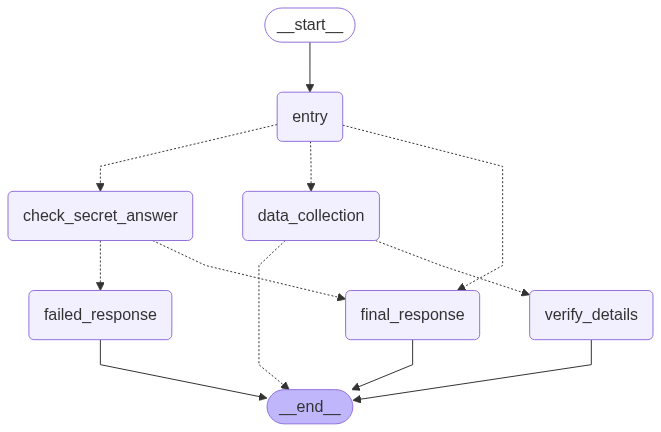

In [9]:
from IPython.display import Image, display

# 1. Create an instance of your helper class
helper = BankingChatHelper2(llm)
app = helper.graph # Get the compiled graph object

# --- Option 1: Get the Mermaid syntax as text ---
print("--- Mermaid Diagram Syntax ---")
print(app.get_graph().draw_mermaid())

# --- Option 2: Display the graph as a PNG image ---
print("\n--- PNG Image of the Graph ---")
# This generates a PNG image of the Mermaid diagram
png_image = app.get_graph().draw_mermaid_png()
display(Image(png_image))